### Unsupervised learning for clustering flower species together

A script to apply unsupervised learning to a dataset with different iris species to see if we can distinguish them.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
iris_data = pd.read_csv('../data/iris_data.csv')
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


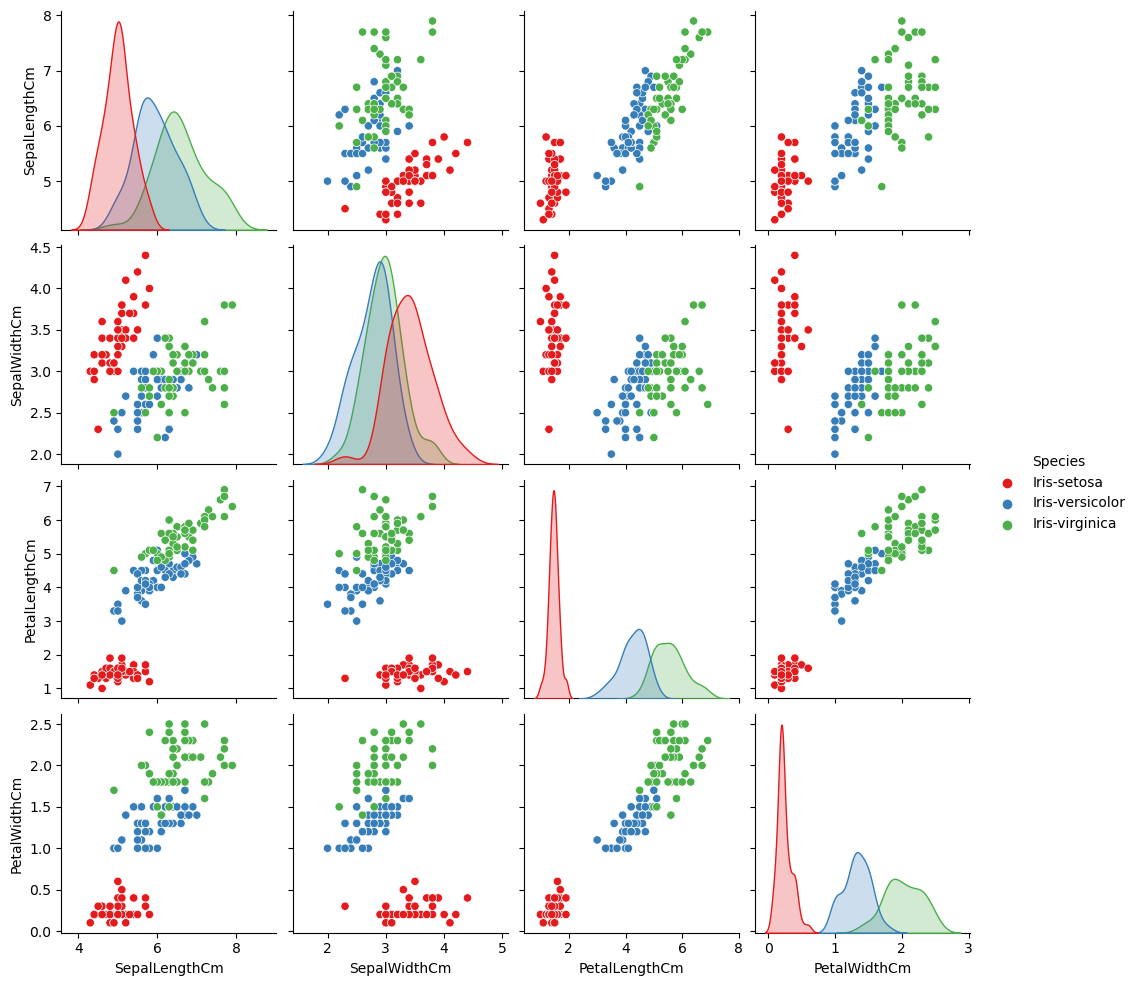

In [14]:
# There are 3 species in the dataset
print(iris_data['Species'].unique())

palette = sns.color_palette("Set1", n_colors=len(iris_data['Species'].unique()))

# Plot combinations of features with species as hue
sns.pairplot(iris_data, vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], hue='Species', palette=palette)
plt.show()

Now we try to recreate something similar using clustering.

In [5]:
# Check for missing values
print(iris_data.isnull().sum())

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


In [15]:
samples = iris_data[ ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'] ].values

# Standardize the features
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Apply PCA
pca = PCA()
pca_scaled_samples = pca.fit_transform(scaled_samples)

In [16]:
# Define model with 3 clusters
model = KMeans(n_clusters=3)
model.fit(pca_scaled_samples)

# Predict the cluster labels
labels = model.predict(pca_scaled_samples)

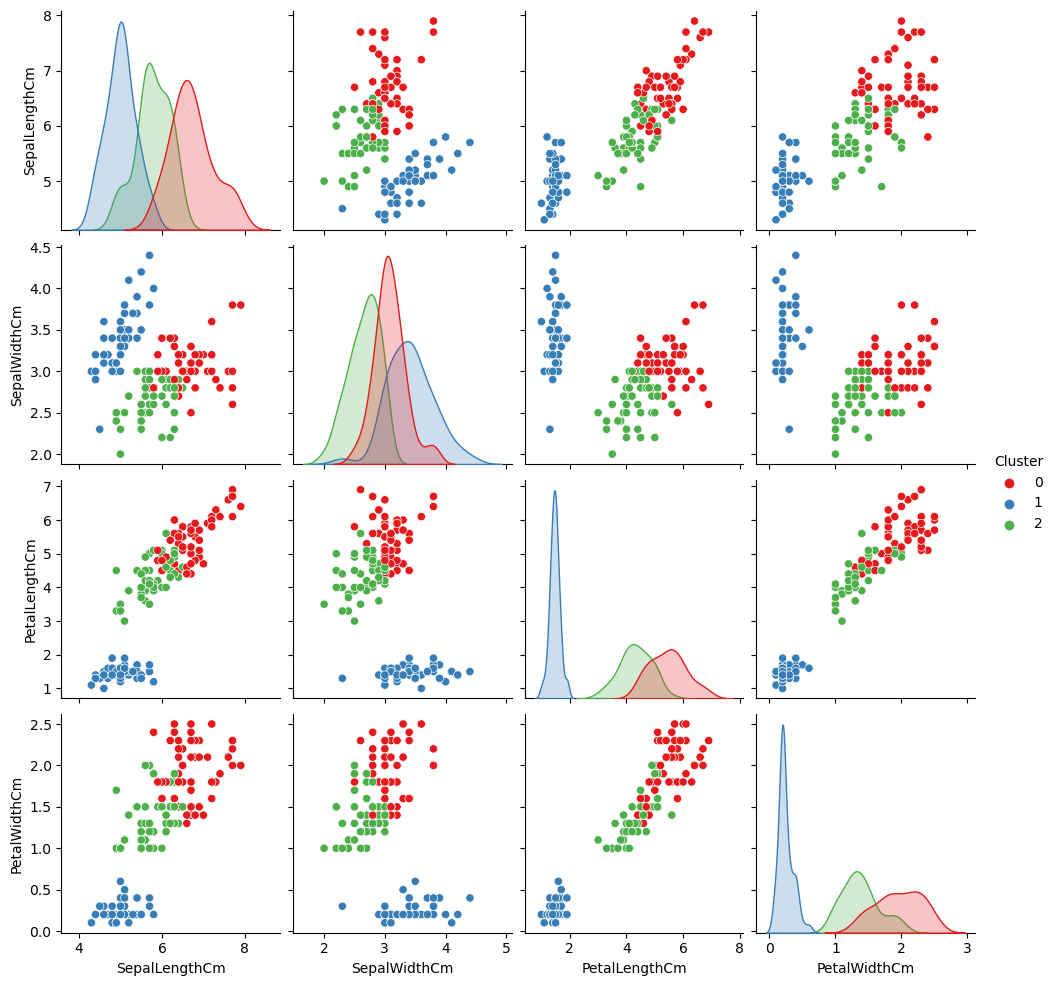

In [17]:
# Plot again with labels as hue
iris_data['Cluster'] = labels
sns.pairplot(iris_data, vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], hue='Cluster', palette=palette)
plt.show()

In [19]:
# So the clustering works pretty well. The numbers correspond like this (it can change each run!):
mapping = {'Iris-versicolor':2, 'Iris-virginica':0, 'Iris-setosa':1}
iris_data['Species_mapped'] = iris_data['Species'].map(mapping)
iris_data[['Cluster', 'Species', 'Species_mapped']].head()	# Compare the clusters with the actual species

,Cluster,Species,Species_mapped
0,1,Iris-setosa,1
1,1,Iris-setosa,1
2,1,Iris-setosa,1
3,1,Iris-setosa,1
4,1,Iris-setosa,1


In [23]:
# Then check how many we got right
correct = sum(iris_data['Cluster'] == iris_data['Species_mapped'])
total = len(iris_data)
accuracy = correct / total
print(f'Accuracy: {100*accuracy:.2f}%')

Accuracy: 84.67%
